In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [39]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 11))

In [40]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271])

In [41]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [42]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [43]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [44]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [45]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

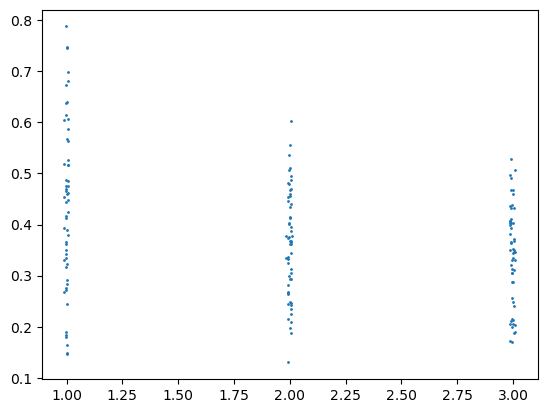

In [46]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [14]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [47]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [48]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(166, 3)


In [49]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [50]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [51]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.52it/s]


Loss: 517.2905675270595
Average Loss: 0.07078414990791727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.70it/s]


Loss: 430.95187986502424
Average Loss: 0.058969879565547924
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.55it/s]


Loss: 428.5118740587495
Average Loss: 0.058635998092330256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.57it/s]


Loss: 428.17002722481266
Average Loss: 0.05858922102145767
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.06it/s]


Loss: 428.20417016372085
Average Loss: 0.05859389301638216
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.47it/s]


Loss: 426.73031953535974
Average Loss: 0.0583922166851888
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.85it/s]


Loss: 426.58683947334066
Average Loss: 0.05837258339810354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.23it/s]


Loss: 426.2669930914417
Average Loss: 0.05832881678864829
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.63it/s]


Loss: 425.70511704916134
Average Loss: 0.05825193172539154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.68it/s]


Loss: 425.3348312797025
Average Loss: 0.058201263174562465
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▋                                                                                                                                                           | 127/7308 [00:03<00:56, 126.66it/s]

X_batch: 
torch.Size([128, 166])
tensor([[0.7582, 0.3409, 0.1572,  ..., 0.4730, 0.1844, 0.3949],
        [0.1969, 0.5951, 0.5214,  ..., 0.4669, 0.2924, 0.2213],
        [0.7057, 0.4155, 0.2349,  ..., 0.6549, 0.1926, 0.4138],
        ...,
        [0.3133, 0.1475, 0.0924,  ..., 0.3113, 0.0885, 0.2128],
        [0.5375, 0.2454, 0.1767,  ..., 0.5183, 0.1808, 0.3157],
        [0.3715, 0.1830, 0.1622,  ..., 0.3684, 0.1728, 0.1496]])
X_pred: 
torch.Size([128, 166])
tensor([[0.4926, 0.3335, 0.2426,  ..., 0.4765, 0.2614, 0.3301],
        [0.5548, 0.3977, 0.3115,  ..., 0.5459, 0.3163, 0.4104],
        [0.6556, 0.4443, 0.3010,  ..., 0.6497, 0.3049, 0.4468],
        ...,
        [0.3022, 0.1503, 0.0988,  ..., 0.2944, 0.1075, 0.1473],
        [0.4931, 0.2617, 0.1461,  ..., 0.4882, 0.1495, 0.2612],
        [0.4250, 0.2293, 0.1428,  ..., 0.4164, 0.1514, 0.2277]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.58it/s]


Loss: 424.87404403230175
Average Loss: 0.0581382107323894
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.51it/s]


Loss: 425.1009087045677
Average Loss: 0.05816925406466444
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.39it/s]


Loss: 424.59373854333535
Average Loss: 0.05809985475415098
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 143.28it/s]


Loss: 424.426713807974
Average Loss: 0.05807699970005118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.92it/s]


Loss: 424.5669435588643
Average Loss: 0.05809618822644558
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.52it/s]


Loss: 423.6759143890813
Average Loss: 0.05797426305269312
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 127.37it/s]


Loss: 424.1360399343539
Average Loss: 0.058037224949966326
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 139.61it/s]


Loss: 424.1745439050719
Average Loss: 0.058042493692538576
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.27it/s]


Loss: 423.5163352810778
Average Loss: 0.057952426831017756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.47it/s]


Loss: 423.80546523304656
Average Loss: 0.05799199031650883
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 132.01it/s]


Loss: 423.57035987311974
Average Loss: 0.05795981935866444
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.34it/s]


Loss: 423.08420461509377
Average Loss: 0.05789329565066965
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.61it/s]


Loss: 423.3161448244937
Average Loss: 0.05792503350088857
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.56it/s]


Loss: 422.4648403809406
Average Loss: 0.0578085441134292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.67it/s]


Loss: 422.69648318947293
Average Loss: 0.05784024126840078
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.50it/s]


Loss: 421.6428989302367
Average Loss: 0.05769607265055237
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.73it/s]


Loss: 422.1882454887964
Average Loss: 0.05777069587969299
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:32<00:00, 78.73it/s]


Loss: 421.3000336396508
Average Loss: 0.05764915621779568
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 108.21it/s]


Loss: 421.48911747918464
Average Loss: 0.057675029759056466
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.64it/s]


Loss: 420.6908024237491
Average Loss: 0.057565791245723745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:05<00:00, 111.13it/s]


Loss: 419.85983991692774
Average Loss: 0.057452085374511186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.73it/s]


Loss: 419.37231425126083
Average Loss: 0.05738537414494538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.80it/s]


Loss: 418.94146004505455
Average Loss: 0.057326417630686174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.75it/s]


Loss: 418.38629791513085
Average Loss: 0.05725045127464845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.91it/s]


Loss: 417.8339683250524
Average Loss: 0.057174872513006625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.84it/s]


Loss: 417.3961461468134
Average Loss: 0.057114962526931226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.12it/s]


Loss: 416.72191478381865
Average Loss: 0.05702270317238898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.96it/s]


Loss: 416.34002545149997
Average Loss: 0.05697044683244389
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 171.81it/s]


Loss: 416.20800281944685
Average Loss: 0.05695238133818375
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:12<00:00, 100.56it/s]


Loss: 416.13535216706805
Average Loss: 0.05694244008854243
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 125.82it/s]


Loss: 415.88343082694337
Average Loss: 0.05690796809345147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 245.31it/s]


Loss: 415.8084000516683
Average Loss: 0.05689770115649539
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.26it/s]


Loss: 415.46425635321066
Average Loss: 0.056850609791079726
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.61it/s]


Loss: 415.42314679315314
Average Loss: 0.05684498450918899
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.30it/s]


Loss: 415.3341061391402
Average Loss: 0.056832800511650274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.90it/s]


Loss: 414.96467548888177
Average Loss: 0.056782248972206045
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.19it/s]


Loss: 414.8341373510193
Average Loss: 0.056764386610703245
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 135.96it/s]


Loss: 414.5642153848894
Average Loss: 0.056727451475764835
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.68it/s]


Loss: 414.62580878683366
Average Loss: 0.056735879691684955
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.74it/s]


Loss: 414.37178558669984
Average Loss: 0.05670112008575531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.43it/s]


Loss: 414.46237113373354
Average Loss: 0.05671351548080645
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.47it/s]


Loss: 413.97514000721276
Average Loss: 0.05664684455490049
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.89it/s]


Loss: 414.02672133455053
Average Loss: 0.05665390275513828
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.12it/s]


Loss: 413.81978895375505
Average Loss: 0.05662558688475028
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.42it/s]


Loss: 413.6496741708834
Average Loss: 0.0566023089998472
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.48it/s]


Loss: 413.79049290833063
Average Loss: 0.05662157812100857
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.88it/s]


Loss: 413.7374624265358
Average Loss: 0.05661432162377337
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.76it/s]


Loss: 413.2731479918584
Average Loss: 0.05655078653418971
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.83it/s]


Loss: 413.1730447825976
Average Loss: 0.05653708877703853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.30it/s]


Loss: 413.1805533096194
Average Loss: 0.05653811621642302
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.13it/s]


Loss: 412.899684793083
Average Loss: 0.056499683195550494
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.60it/s]


Loss: 412.7551443646662
Average Loss: 0.05647990481180435
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.91it/s]


Loss: 412.61385846766643
Average Loss: 0.05646057176623788
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.67it/s]


Loss: 412.3580695532728
Average Loss: 0.05642557054642485
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 138.59it/s]


Loss: 412.31482118717395
Average Loss: 0.05641965259813546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 165.95it/s]


Loss: 412.3457418854814
Average Loss: 0.05642388367343752
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.06it/s]


Loss: 412.0891003392171
Average Loss: 0.05638876578259676
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.72it/s]


Loss: 412.004366198089
Average Loss: 0.05637717107253544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:37<00:00, 75.02it/s]


Loss: 411.85524724354036
Average Loss: 0.056356766180013736
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.76it/s]


Loss: 411.59520061453804
Average Loss: 0.056321182350100994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 137.09it/s]


Loss: 411.4827099402901
Average Loss: 0.056305789537532853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.48it/s]


Loss: 411.6630199227948
Average Loss: 0.056330462496277336
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.21it/s]


Loss: 411.411700965371
Average Loss: 0.0562960729290327
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 169.16it/s]


Loss: 411.19145824434236
Average Loss: 0.05626593572035336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.76it/s]


Loss: 411.28706848132424
Average Loss: 0.0562790186756054
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.29it/s]


Loss: 411.19460899266414
Average Loss: 0.056266366857233734
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.55it/s]


Loss: 411.2807649099268
Average Loss: 0.056278156117942915
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.33it/s]


Loss: 411.0878185138572
Average Loss: 0.05625175403856831
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.89it/s]


Loss: 411.1421413095668
Average Loss: 0.05625918737131456
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:14<00:00, 97.67it/s]


Loss: 411.0354995073285
Average Loss: 0.056244594897007186
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.25it/s]


Loss: 411.0097842498217
Average Loss: 0.0562410761151918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.74it/s]


Loss: 410.9193855407648
Average Loss: 0.05622870628636628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.77it/s]


Loss: 410.9013954875991
Average Loss: 0.05622624459326753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.83it/s]


Loss: 410.75874903285876
Average Loss: 0.0562067253739544
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.37it/s]


Loss: 410.70515270670876
Average Loss: 0.05619939144864652
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 103.90it/s]


Loss: 410.6500089862384
Average Loss: 0.05619184578355752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 117.74it/s]


Loss: 410.6666053591762
Average Loss: 0.05619411677054956
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 96.57it/s]


Loss: 410.7052627543453
Average Loss: 0.05619940650716274
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:09<00:00, 105.19it/s]


Loss: 410.4878661266994
Average Loss: 0.05616965874749581
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:06<00:00, 109.50it/s]


Loss: 410.4821604581084
Average Loss: 0.05616887800466727
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 119.55it/s]


Loss: 410.4457373917103
Average Loss: 0.05616389400543381
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.90it/s]


Loss: 410.10256790951826
Average Loss: 0.05611693594820994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.91it/s]


Loss: 410.2089167512022
Average Loss: 0.0561314883348662
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.80it/s]


Loss: 410.2610480892472
Average Loss: 0.05613862179655818
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.63it/s]


Loss: 410.1092288335785
Average Loss: 0.056117847404704234
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 114.32it/s]


Loss: 409.9140424414072
Average Loss: 0.0560911388124531
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.23it/s]


Loss: 409.93590010679327
Average Loss: 0.05609412973546706
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.37it/s]


Loss: 409.91548003884964
Average Loss: 0.056091335528030875
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.69it/s]


Loss: 410.209829548141
Average Loss: 0.05613161323866188
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:10<00:00, 104.07it/s]


Loss: 410.153374575777
Average Loss: 0.056123888146658044
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.43it/s]


Loss: 409.765396958217
Average Loss: 0.05607079870802094
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.80it/s]


Loss: 409.8426648916211
Average Loss: 0.05608137176951575
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.31it/s]


Loss: 409.85414385213517
Average Loss: 0.05608294250850235
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.35it/s]


Loss: 409.8973079295829
Average Loss: 0.0560888489230409
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.37it/s]


Loss: 409.75366106047295
Average Loss: 0.05606919281068322
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.32it/s]


Loss: 409.604387041647
Average Loss: 0.05604876669973276
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.42it/s]


Loss: 409.69972594222054
Average Loss: 0.056061812526302754
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.61it/s]


Loss: 409.5974672008306
Average Loss: 0.05604781981401623
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.97it/s]


Loss: 409.5815308187157
Average Loss: 0.056045639137755295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.86it/s]


Loss: 409.57106512458995
Average Loss: 0.0560442070504365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.66it/s]


Loss: 409.38597113103606
Average Loss: 0.056018879465111665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.31it/s]


Loss: 409.46002385695465
Average Loss: 0.05602901256936982
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.05it/s]


Loss: 409.31702049751766
Average Loss: 0.05600944451252294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.35it/s]


Loss: 409.3200013441965
Average Loss: 0.0560098524006837
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 159.00it/s]


Loss: 409.35222185216844
Average Loss: 0.0560142613371878
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 92.88it/s]


Loss: 409.344948790269
Average Loss: 0.056013266117989735
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.40it/s]


Loss: 409.33658654266037
Average Loss: 0.056012121858601584
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.20it/s]


Loss: 409.31032658414915
Average Loss: 0.05600852854189233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.77it/s]


Loss: 409.20545343705453
Average Loss: 0.05599417808388814
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.16it/s]


Loss: 409.1481705906335
Average Loss: 0.05598633970862528
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.06it/s]


Loss: 408.93548931297846
Average Loss: 0.05595723718021052
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.35it/s]


Loss: 409.1090447648894
Average Loss: 0.05598098587368492
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.93it/s]


Loss: 409.127146321116
Average Loss: 0.05598346282445485
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.34it/s]


Loss: 408.95387984486297
Average Loss: 0.055959753673352895
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:07<00:00, 107.59it/s]


Loss: 408.9556502865162
Average Loss: 0.05595999593411551
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.74it/s]


Loss: 408.81338715017773
Average Loss: 0.05594052916669099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.26it/s]


Loss: 408.8949881340377
Average Loss: 0.05595169514696739
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:57<00:00, 126.55it/s]


Loss: 409.01174468756653
Average Loss: 0.05596767168685913
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 123.41it/s]


Loss: 408.79796106065623
Average Loss: 0.05593841831700277
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.13it/s]


Loss: 408.77984548616223
Average Loss: 0.055935939448024385
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.58it/s]


Loss: 408.971913741203
Average Loss: 0.05596222136579133
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.69it/s]


Loss: 408.88966937805526
Average Loss: 0.05595096734784555
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 113.37it/s]


Loss: 408.7193853408098
Average Loss: 0.055927666302792806
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.60it/s]


Loss: 408.67588368593715
Average Loss: 0.0559217136953937
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.22it/s]


Loss: 408.6589050695766
Average Loss: 0.05591939040360928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.04it/s]


Loss: 408.6130432912614
Average Loss: 0.05591311484554754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:58<00:00, 124.83it/s]


Loss: 398.337359477533
Average Loss: 0.05450702784312165
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 107.09it/s]


Loss: 408.6880449396558
Average Loss: 0.05592337779688777
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.46it/s]


Loss: 408.5006677119527
Average Loss: 0.05589773778215007
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:59<00:00, 122.43it/s]


Loss: 408.5842824028805
Average Loss: 0.055909179310738986
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 102.49it/s]


Loss: 408.55081484583206
Average Loss: 0.05590459973259881
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:01<00:00, 118.16it/s]


Loss: 408.40508676017635
Average Loss: 0.05588465883417848
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.29it/s]


Loss: 408.5159424713347
Average Loss: 0.055899827924375305
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 6


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:44<00:00, 70.16it/s]


Loss: 408.434029705124
Average Loss: 0.05588861928094198
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.86it/s]


Loss: 408.47417766042054
Average Loss: 0.055894112980353114
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.76it/s]


Loss: 408.4115206145216
Average Loss: 0.055885539219283194
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 9


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 98.80it/s]

Loss: 408.3139022956602
Average Loss: 0.055872181485448855
Done, best loss: 398.337359477533
Done


<All keys matched successfully>

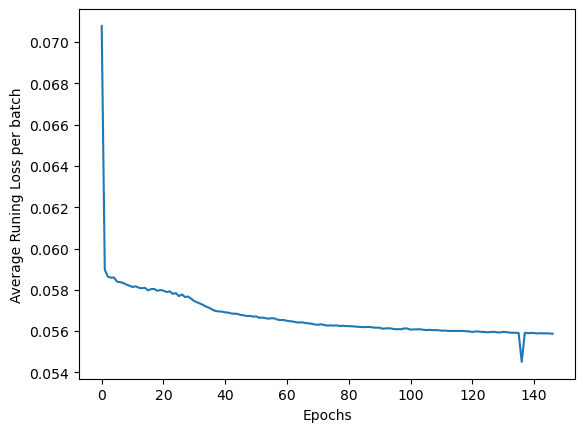

In [52]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [53]:
torch.save(final_model, 'model_100206_11g_04.pt')